In [12]:
#libraries needed for the custom helper function
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import random

## custom function for loading data from the directory
def load_data(base_folder_path,resize=(224,224),test_size=0.2, random_state = 4):
    data=[] #for storing images
    labels=[]   #for storing labels
    path_images = []    #for storing image path
    
    types = sorted(list(os.listdir(base_folder_path)))
    
    #storing images, labels and path 
    for item in types:
        path = sorted(list(os.listdir(base_folder_path+'/'+item)))
        for images in path:
            img_path = base_folder_path+'/'+item+'/'+images
            path_images.append((item,img_path))
            img = cv2.imread(img_path)
            img = cv2.resize(img,resize)
            data.append(img)
            labels.append(item)
    
    #converting images to numpy array and normalizing
    data = np.array(data)
    data = data.astype('float32')/255
    
    #encoding labels
    labels = np.array(labels)
    Lbinary = LabelBinarizer()
    Y = Lbinary.fit_transform(labels)
    
    #for storing labels in dataframe
    enc = []
    for i in range(len(Y)):
        enc.append(' '.join(str(e) for e in Y[i]))
    
    #generating pandas data frame    
    data_df = pd.DataFrame(data=path_images,columns=['items','path'])
    data_df.insert(2,"label encoding",enc,True)
    
    Xs,Ys = shuffle(data,Y)
    X_train,X_test,Y_train,Y_test = train_test_split(Xs,Ys,test_size=test_size,random_state=random_state)
    
    return data_df,X_train,X_test,Y_train,Y_test

## custom function for plotting accuracy with the given model history
def plot(history):
    %matplotlib inline
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) #No. of epochs
    plt.plot(epochs,acc,'b',label='Training Accuracy')
    plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
    plt.legend()
    plt.figure()

    #Plot training and validation loss per epoch
    plt.plot(epochs,loss,'b',label='Training Loss')
    plt.plot(epochs,val_loss,'r',label='Validation Loss')
    plt.legend()
    plt.show()

## custom function for performing model evaluation
def my_model_evaluation(model,X_test,Y_test):
    xtest=X_test
    ytest=Y_test
    ypred = model.predict(xtest)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
            
        total += 1
        
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')
    
    return accurateindex, wrongindex

## custom function for seeing model output
def my_model_output(dataset_path, model,X_test, Y_test,accurateindex, wrongindex,correct=True):    
        xtest=X_test
        ytest=Y_test
        ypred = model.predict(xtest)
        label=sorted(list(os.listdir(dataset_path)))
        if(correct):
            imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'
        else:
            imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'
        
        nrows = 3
        ncols = 3
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

        n = 0
        for row in range(nrows):
            for col in range(ncols):
                    ax[row,col].imshow(xtest[imidx[n]])
                    ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
                    n += 1

        plt.show()    
        

### Loading Data
#### Loading data from the provided directory path with each class with a separate folder in the directory

In [4]:
#loading data
img_rows, img_cols = 224,224
df,X_train,X_test,Y_train,Y_test = load_data(base_folder_path="cars",resize=(img_rows,img_cols),test_size=0.05,random_state=10)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
df.head()

(3184, 224, 224, 3)
(168, 224, 224, 3)
(3184, 7)
(168, 7)


,items,path,label encoding
0,Audi,cars/Audi/1.jpg,1 0 0 0 0 0 0
1,Audi,cars/Audi/10.jpg,1 0 0 0 0 0 0
2,Audi,cars/Audi/100.jpg,1 0 0 0 0 0 0
3,Audi,cars/Audi/1001.jpg,1 0 0 0 0 0 0
4,Audi,cars/Audi/1002.jpg,1 0 0 0 0 0 0


### Loading Model
#### Loading Pretrained VGG16 Model

In [5]:
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16

#dense net model for transfer learning
def my_Model(base_model,img_row,img_cols,channel,classes):
    
    inputs = Input(shape=(img_row,img_cols,channel))
    x = base_model(inputs,training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes,activation='softmax')(x)
    model = Model(inputs,outputs)
    return model

#loading model
classes = Y_test.shape[1]
channel = 3
    
base_model = VGG16(include_top=False,input_shape=(img_rows,img_cols,channel))
base_model.trainable = False
    
model = my_Model(base_model=base_model,img_row=img_rows,img_cols=img_cols,channel=channel,classes=classes)
    
model.summary()
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    

2024-02-15 19:24:24.709076: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 19:24:24.872496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 19:24:24.872529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 19:24:24.899600: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 19:24:24.954954: I tensorflow/core/platform/cpu_feature_guar

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)         │ 14,714,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d        │ (None, 512)               │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 7)                 │      3,591 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Performing Training On the Pretrained Model

In [6]:
batch_size = 16
nb_epoch = 10
filepath = "{epoch:02d}-{val_loss:.2f}.keras"
checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,Y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_test,Y_test),
                    callbacks=callbacks_list)

Epoch 1/10


2024-02-15 19:26:33.282870: I external/local_xla/xla/service/service.cc:168] XLA service 0x95c5fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 19:26:33.282906: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-02-15 19:26:33.312174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 19:26:33.440194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


  8/199 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1009 - loss: 2.0763

I0000 00:00:1708007195.767971   73033 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2714 - loss: 1.8622
Epoch 1: val_accuracy improved from -inf to 0.46429, saving model to 01-1.64.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.2716 - loss: 1.8618 - val_accuracy: 0.4643 - val_loss: 1.6423
Epoch 2/10
197/199 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4318 - loss: 1.6056
Epoch 2: val_accuracy improved from 0.46429 to 0.47619, saving model to 02-1.48.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4320 - loss: 1.6053 - val_accuracy: 0.4762 - val_loss: 1.4809
Epoch 3/10
197/199 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4989 - loss: 1.4842
Epoch 3: val_accuracy improved from 0.47619 to 0.63690, saving model to 03-1.37.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4993 - loss: 1.4837 - val_accuracy: 0.6369 - val_loss: 1.3705
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5721 - loss: 1.3613
Epoch 4: val_accuracy improved from 0.63690 to 0.66071

### Plotting Accuracy and Loss

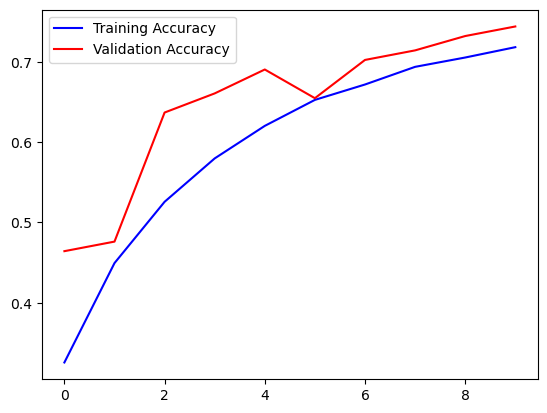

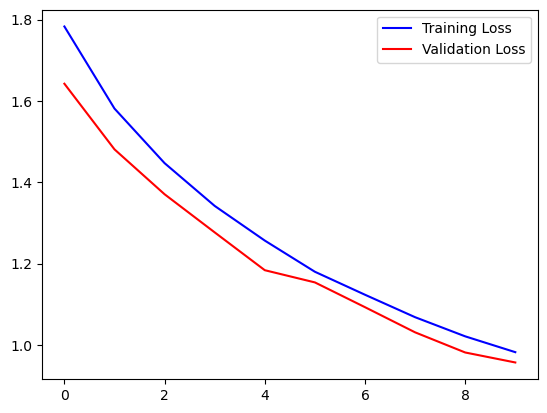

In [7]:
plot(history)

### Evaluating Model on Test Dataset

In [8]:
accurate_index, wrong_index = my_model_evaluation(model,X_test,Y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step
Total-test-data; 168 	accurately-predicted-data: 126 	 wrongly-predicted-data:  42
Accuracy: 75.0 %


### Showing Some Correct Predicted Output

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


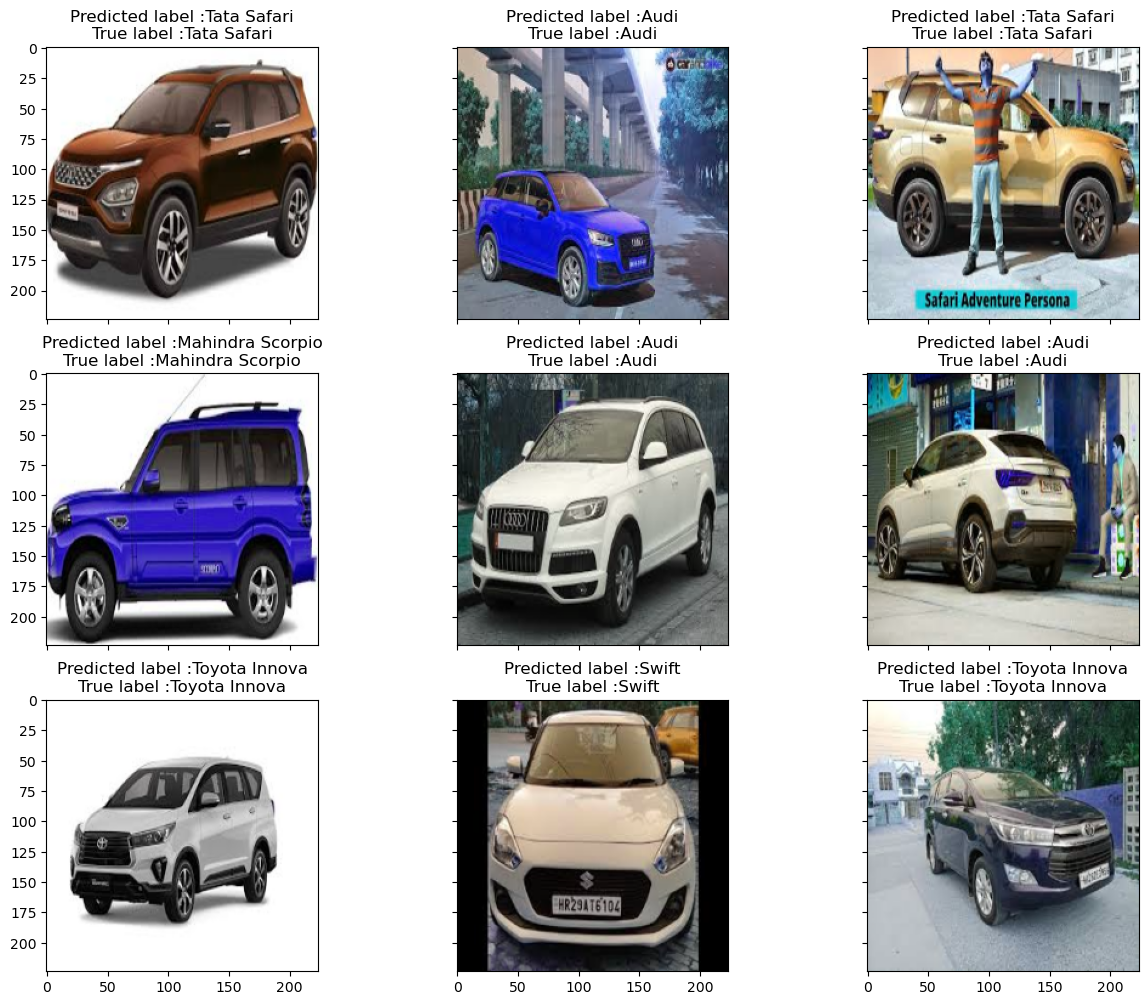

In [13]:
my_model_output("cars",model,X_test,Y_test, accurate_index, wrong_index,correct=True)

### Showing Some Wrong Predicted Output

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step 


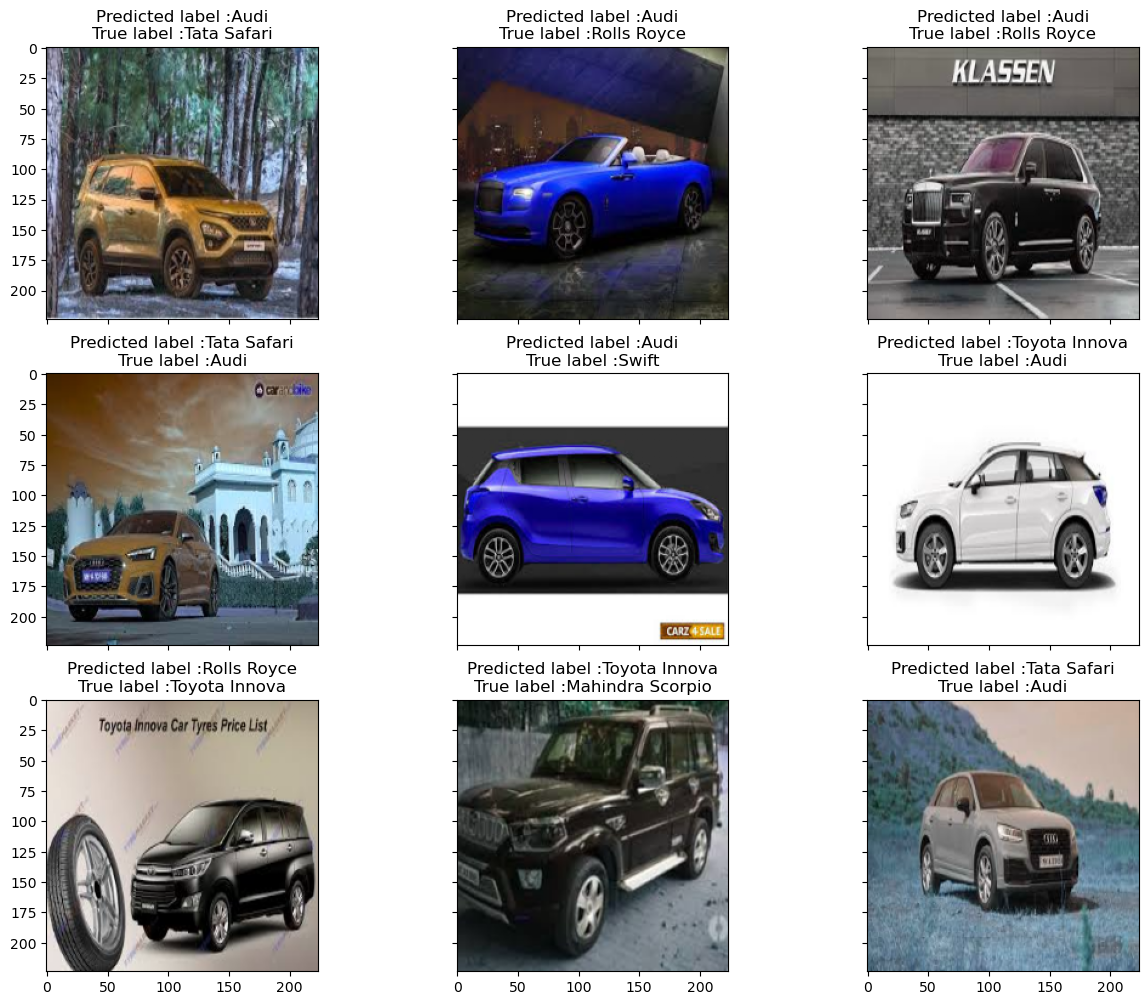

In [14]:
my_model_output("cars",model,X_test,Y_test, accurate_index, wrong_index,correct= False)

In [2]:
from keras.applications.vgg16 import VGG16
model = VGG16()


In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
from keras.utils import load_img
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
image = load_img('dog.jpeg',target_size=(224,224))
image = np.array(image)
image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
image = preprocess_input(image)
image
my_image = cv2.imread('dog.jpeg')


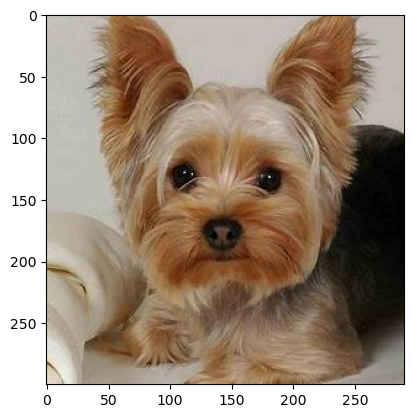

In [5]:
from matplotlib import pyplot as plt
my_image = cv2.cvtColor(my_image,cv2.COLOR_BGR2RGB)
plt.imshow(my_image)

In [6]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
yhat = model.predict(image)
label = decode_predictions(yhat)
label

1/1 [==============================] - 3s 3s/step


[[('n02094433', 'Yorkshire_terrier', 0.9599559),
  ('n02096294', 'Australian_terrier', 0.016696451),
  ('n02097658', 'silky_terrier', 0.013871724),
  ('n02094114', 'Norfolk_terrier', 0.004175216),
  ('n02087046', 'toy_terrier', 0.0010187156)]]

In [7]:
#!pip install keras_applications


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from __future__ import print_function
import numpy as np
import warnings

from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils import get_source_inputs
import tensorflow as tf
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [2]:
def VGGupdated(input_tensor=None,classes=10):
    img_rows, img_cols = 300,300
    img_channels = 3
    img_dim = (img_rows,img_cols,img_channels)
    img_input = Input(shape=img_dim)

    #Block 1
    x = Conv2D(64,(3,3),activation='relu',padding='same',name='block1_conv1')(img_input)
    x = Conv2D(64,(3,3),activation='relu',padding='same',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block1_pool')(x)
    
    #Block 2
    x = Conv2D(128,(3,3),activation='relu',padding='same',name='block2_conv1')(x)
    x = Conv2D(128,(3,3),activation='relu',padding='same',name='block2_conv2')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block2_pool')(x)

    #Block 3
    x = Conv2D(256,(3,3),activation='relu',padding='same',name='block3_conv1')(x)
    x = Conv2D(256,(3,3),activation='relu',padding='same',name='block3_conv2')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block3_pool')(x)

    #Block 4
    x = Conv2D(512,(3,3),activation='relu',padding='same',name='block4_conv1')(x)
    x = Conv2D(512,(3,3),activation='relu',padding='same',name='block4_conv2')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block4_pool')(x)

    #Block 5
    x = Conv2D(512,(3,3),activation='relu',padding='same',name='block5_conv1')(x)
    x = Conv2D(512,(3,3),activation='relu',padding='same',name='block5_conv2')(x)
    x = MaxPooling2D(pool_size=(2,2),strides=(2,2),name='block5_pool')(x)

    x = Flatten(name='flatten')(x)

    #fully connected layer
    x = Dense(4096,activation='relu',name='fc1')(x)
    x = Dense(4096,activation='relu',name='fc2')(x)
    x = Dense(classes,activation='softmax',name='predictions')(x)

    #create model 
    model = Model(inputs=img_input,outputs=x,name='VGGdemo')

    return model


In [16]:
with tf.device('/CPU:0'):
    #for model
    model = VGGupdated(classes=7)
    model.summary()
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    

Model: "VGGdemo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [19]:
import cv2
with tf.device('/CPU:0'):
    #for input images
    datapath_path = os.listdir('cars/')
    print(datapath_path)
    images = []
    labels = []
    for item in datapath_path:
        path = 'cars/'+str(item)
        files = [i for i in os.listdir(path)]
        for f in files:
            img = cv2.imread(path+'/'+f)
            img = cv2.resize(img,(300,300))
            images.append(img)
            labels.append(item)
    images = np.array(images)
    images = images.astype('float32')/255
    images.shape
    
    #y = np.reshape(y,(-1,1))
    #y_one_encoder = OneHotEncoder()
    #Y = y_one_encoder.fit_transform(y)
    #Y.shape

    

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [17]:
#for labels
y_label_encoder = LabelEncoder()
y = y_label_encoder.fit_transform(labels)
y = y.reshape(-1,1)

print(y)

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (3327, 6)	1.0
  (3328, 6)	1.0
  (3329, 6)	1.0
  (3330, 6)	1.0
  (3331, 6)	1.0
  (3332, 6)	1.0
  (3333, 6)	1.0
  (3334, 6)	1.0
  (3335, 6)	1.0
  (3336, 6)	1.0
  (3337, 6)	1.0
  (3338, 6)	1.0
  (3339, 6)	1.0
  (3340, 6)	1.0
  (3341, 6)	1.0
  (3342, 6)	1.0
  (3343, 6)	1.0
  (3344, 6)	1.0
  (3345, 6)	1.0
  (3346, 6)	1.0
  (3347, 6)	1.0
  (3348, 6)	1.0
  (3349, 6)	1.0
  (3350, 6)	1.0
  (3351, 6)	1.0


In [7]:
#train and test set
images,y = shuffle(images,y,random_state=1)
train_x,test_x,train_y,test_y = train_test_split(images,y,test_size=0.2,random_state=415)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2681, 300, 300, 3)
(671, 300, 300, 3)
(2681, 1)
(671, 1)


In [8]:
#tf.debugging.set_log_device_placement(True)
#train_x = train_x.to_array
#train_y = train_y.to_array
with tf.device('/GPU:0'):
    model.fit(train_x,train_y,epochs=10,batch_size=16)

Epoch 1/10
168/168 [==============================] - 77s 382ms/step - loss: 2.2382 - accuracy: 0.2372
Epoch 2/10
168/168 [==============================] - 60s 355ms/step - loss: 1.8609 - accuracy: 0.2436
Epoch 3/10
168/168 [==============================] - 60s 360ms/step - loss: 1.8624 - accuracy: 0.2327
Epoch 4/10
168/168 [==============================] - 62s 368ms/step - loss: 1.8606 - accuracy: 0.2260
Epoch 5/10
168/168 [==============================] - 60s 356ms/step - loss: 1.8570 - accuracy: 0.2465
Epoch 6/10
168/168 [==============================] - 60s 355ms/step - loss: 1.8588 - accuracy: 0.2372
Epoch 7/10
168/168 [==============================] - 60s 356ms/step - loss: 1.8578 - accuracy: 0.2436
Epoch 8/10
168/168 [==============================] - 60s 356ms/step - loss: 1.8577 - accuracy: 0.2417
Epoch 9/10
168/168 [==============================] - 59s 354ms/step - loss: 1.8585 - accuracy: 0.2335
Epoch 10/10
168/168 [==============================] - 60s 354ms/step - l

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     